In [7]:
import pandas as pd
import numpy as np
from fairlearn.metrics import *
from fairlearn.reductions import ErrorRate, DemographicParity, ExponentiatedGradient, EqualizedOdds
from fairlearn.adversarial import AdversarialFairnessClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import sklearn
import time
from functools import partial
import warnings
from sklearn.exceptions import ConvergenceWarning
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import wasserstein_distance

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def impute_income(df):
    df['income_current'] = df['income_current'].replace(99999999, np.nan)
    df['income_current'] = df['income_current'].replace(99999998, np.nan)
    df['income_current'] = df['income_current'].replace(-999, np.nan)
    df['income_current'] = df['income_current'].fillna(df['income_current'].median())
    return df

def impute_age(df):
    df['age'] = df['age'].fillna(df['age'].median())
    return df

def split_dataset_into_x_y(dataset, target_label = 'mortality_ten_years'):
    X_dataset = dataset.drop(columns=['mortality_ten_years', 'mortality_five_years', 'year_death', 'HHID', 'PN'])
    y_dataset = dataset[target_label]
    return X_dataset, y_dataset

def train_over_iterations(model, X_data, y_data, iterations, sensitive_a_data=None):
    training_accuracies = []
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        # Train for multiple iterations manually
        for i in tqdm(range(1, iterations + 1)):
            if isinstance(model, Pipeline):
                model[-1].set_params(max_iter=i)
            else:
                model.set_params(max_iter=i)
            if sensitive_a_data is not None:
                model.fit(X_data, y_data, sensitive_features=sensitive_a_data)
            else:
                model.fit(X_data, y_data)
            y_train_pred = model.predict(X_data)
            acc = accuracy_score(y_data, y_train_pred)
            training_accuracies.append(acc)
    
    # Plot training accuracy
    plt.plot(range(1, len(training_accuracies) + 1), training_accuracies, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Training Accuracy')
    plt.title('Training Accuracy per Iteration')
    plt.show()

def evaluate(model, X_id_test, y_id_test, X_ood_test, y_ood_test):
    y_id_pred = model.predict(X_id_test)
    y_ood_pred = model.predict(X_ood_test)
    print(f"ID Test Results: \n{classification_report(y_id_test, y_id_pred)}")
    print(f"OOD Test Results: \n{classification_report(y_ood_test, y_ood_pred)}")


## Regular Log Reg

#1

In [60]:
data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')
train_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
id_test_df = data_dict['2012']
ood_test_df = pd.concat([data_dict['2014'], data_dict['2016']], ignore_index=True)

train_df = train_df.fillna(-999)
id_test_df = id_test_df.fillna(-999)
ood_test_df = ood_test_df.fillna(-999)

X_train, y_train = split_dataset_into_x_y(train_df, 'mortality_ten_years')
X_id_test, y_id_test = split_dataset_into_x_y(id_test_df, 'mortality_ten_years')
X_ood_test, y_ood_test = split_dataset_into_x_y(ood_test_df, 'mortality_ten_years')

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_20264/494265104.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_20264/494265104.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df = train_df.fillna(-999)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_20264/494265104.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffi

(55267, 181)
(19514, 181)
(37460, 181)


In [61]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

was_dist_1 = {}

for attribute in protected_attributes:
    if (attribute == "income_current"):
        X_train = impute_income(X_train)
        X_id_test = impute_income(X_id_test)
        X_ood_test = impute_income(X_ood_test)
        
        wd_id = wasserstein_distance(X_train[attribute], X_id_test[attribute])
        wd_ood = wasserstein_distance(X_train[attribute], X_ood_test[attribute])
    elif (attribute == "age"):
        X_train = impute_age(X_train)
        X_id_test = impute_age(X_id_test)
        X_ood_test = impute_age(X_ood_test)
        
        wd_id = wasserstein_distance(X_train[attribute], X_id_test[attribute])
        wd_ood = wasserstein_distance(X_train[attribute], X_ood_test[attribute])
    else: #since other attributes are categorical, need to do by one-hot encoding
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        train_encoded = encoder.fit_transform(X_train[attribute].to_frame())
        id_test_encoded = encoder.transform(X_id_test[attribute].to_frame())
        ood_test_encoded = encoder.transform(X_ood_test[attribute].to_frame())

        wd_id = np.mean([wasserstein_distance(train_encoded[:, i], id_test_encoded[:, i]) 
                        for i in range(train_encoded.shape[1])])
        wd_ood = np.mean([wasserstein_distance(train_encoded[:, i], ood_test_encoded[:, i]) 
                        for i in range(train_encoded.shape[1])])

    print(f'Wasserstein distance for {attribute}:')
    print(f'ID test: {wd_id}')
    print(f'OOD test: {wd_ood}')
    print(f'difference(OOD v ID): {wd_ood - wd_id}\n')
    was_dist_1[attribute] = [0, wd_id, wd_ood]

Wasserstein distance for race:
ID test: 0.04980390779616057
OOD test: 0.07368226451799831
difference(OOD v ID): 0.02387835672183774

Wasserstein distance for gender:
ID test: 0.002975580717131332
OOD test: 0.0007348387492601971
difference(OOD v ID): -0.002240741967871135

Wasserstein distance for state_live_current:
ID test: 0.01666701440909173
OOD test: 0.017574250719636624
difference(OOD v ID): 0.0009072363105448941

Wasserstein distance for income_current:
ID test: 3846.767831205235
OOD test: 33967.45748507574
difference(OOD v ID): 30120.689653870508

Wasserstein distance for age:
ID test: 0.7091659745368468
OOD test: 0.8568643363314056
difference(OOD v ID): 0.14769836179455875

Wasserstein distance for education_current:
ID test: 0.009234915977155228
OOD test: 0.0007674542375477984
difference(OOD v ID): -0.00846746173960743



  0%|          | 0/250 [00:00<?, ?it/s]

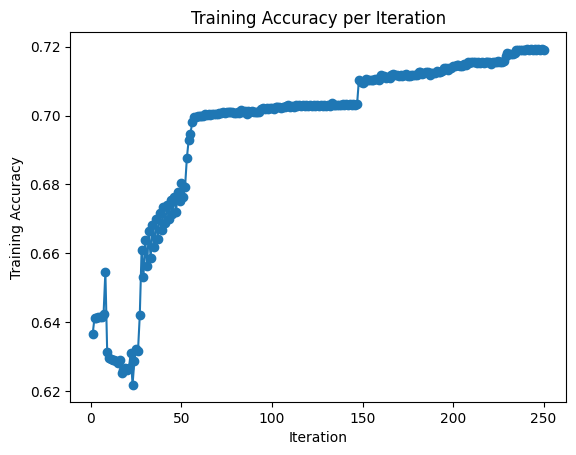

ID Test Results: 
              precision    recall  f1-score   support

           0       0.82      0.90      0.86     15001
           1       0.51      0.35      0.42      4513

    accuracy                           0.77     19514
   macro avg       0.67      0.62      0.64     19514
weighted avg       0.75      0.77      0.76     19514

OOD Test Results: 
              precision    recall  f1-score   support

           0       0.94      0.91      0.92     34757
           1       0.18      0.26      0.21      2703

    accuracy                           0.86     37460
   macro avg       0.56      0.58      0.57     37460
weighted avg       0.89      0.86      0.87     37460



In [12]:
X_train_filled = X_train.fillna(-999)
X_id_test_filled = X_id_test.fillna(-999)
X_ood_test_filled = X_ood_test.fillna(-999)

logistic_reg = LogisticRegression(max_iter=1, warm_start=True, random_state=42)
train_over_iterations(logistic_reg, X_train_filled, y_train, 250)
evaluate(logistic_reg, X_id_test_filled, y_id_test, X_ood_test_filled, y_ood_test)

In [13]:
import joblib

joblib.dump(logistic_reg, 'logistic_reg.pkl')

['logistic_reg.pkl']

In [ ]:
from sklearn.calibration import calibration_curve

def statistical_parity(y_pred, sensitive_attr):
    groups = sensitive_attr.unique()
    rates = {}
    for group in groups:
        mask = sensitive_attr == group
        rates[group] = y_pred[mask].mean()
    return max(rates.values()) - min(rates.values())

def equalized_odds(y_true, y_pred, sensitive_attr):
    # Ensure indices are aligned
    sensitive_attr = sensitive_attr.loc[y_true.index]
    
    groups = sensitive_attr.unique()
    fpr_diffs, fnr_diffs = [], []
    
    for group in groups:
        mask = sensitive_attr == group
        y_true_group = y_true[mask]
        y_pred_group = y_pred[mask]
        
        # Calculate False Positive Rate (FPR) safely
        tn_fp = sum(y_true_group == 0)
        if tn_fp > 0:
            fpr = sum((y_pred_group == 1) & (y_true_group == 0)) / tn_fp
        else:
            fpr = 0  # Set FPR to 0 if no true negatives

        # Calculate False Negative Rate (FNR) safely
        tp_fn = sum(y_true_group == 1)
        if tp_fn > 0:
            fnr = sum((y_pred_group == 0) & (y_true_group == 1)) / tp_fn
        else:
            fnr = 0  # Set FNR to 0 if no true positives

        # Track differences
        fpr_diffs.append(fpr)
        fnr_diffs.append(fnr)
    
    # Calculate the maximum difference between groups
    max_fpr_diff = max(fpr_diffs) - min(fpr_diffs)
    max_fnr_diff = max(fnr_diffs) - min(fnr_diffs)
    
    return max(max_fpr_diff, max_fnr_diff)

def group_calibration(y_true, y_prob, sensitive_attr):
    groups = sensitive_attr.unique()
    calibration_results = {}
    for group in groups:
        mask = sensitive_attr == group
        y_true_group = y_true[mask]
        y_prob_group = y_prob[mask]
        prob_true, prob_pred = calibration_curve(y_true_group, y_prob_group, n_bins=10)
        calibration_results[group] = (prob_true, prob_pred)
    return calibration_results

# Function to calculate the maximum calibration gap
def calculate_max_calibration_gap(calibration_results):
    max_gap = 0
    for group, (prob_true, prob_pred) in calibration_results.items():
        # Compute absolute differences for the group
        group_gaps = [abs(t - p) for t, p in zip(prob_true, prob_pred)]
        # Update the max gap if this group has a larger one
        max_gap = max(max_gap, max(group_gaps))
    return max_gap

def get_fairness_metrics(model, sensitive_attr=""):

    if sensitive_attr != "":
        protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']
    else:
        protected_attributes = [sensitive_attr]
    all_sp = {}
    all_eo = {}
    all_max_gap = {}

    for attribute in protected_attributes:
        print(f"{attribute}:\n")
        attr_sp = []
        attr_eo = []
        attr_max_gap = []

        for dataset_name, (X, y, sensitive_attr) in {
            "Train": (X_train, y_train, X_train[attribute]),
            "ID Test": (X_id_test, y_id_test, X_id_test[attribute]),
            "OOD Test": (X_ood_test, y_ood_test, X_ood_test[attribute]),
        }.items():
            y_pred = model.predict(X)
            sp = statistical_parity(y_pred, sensitive_attr)
            print(f"Statistical Parity Difference ({dataset_name}): {sp}")
            attr_sp.append(sp)

            eo = equalized_odds(y, y_pred, sensitive_attr)
            print(f"Equalized Odds Difference ({dataset_name}): {eo}")
            attr_eo.append(eo)

            y_prob = model.predict_proba(X)[:, 1]
            calibration_train = group_calibration(y, y_prob, sensitive_attr)
            max_gap = calculate_max_calibration_gap(calibration_train)
            print(f"Max Calibration Gap ({dataset_name}): {max_gap}\n")
            attr_max_gap.append(max_gap)

        all_sp[attribute] = attr_sp
        all_eo[attribute] = attr_eo
        all_max_gap[attribute] = attr_max_gap
    
    return all_sp, all_eo, all_max_gap

In [62]:
all_sp_1, all_eo_1, all_max_gap_1 = get_fairness_metrics(logistic_reg)

race:

Statistical Parity Difference (Train): 0.32728372655777377
Equalized Odds Difference (Train): 0.5503485670023238
Max Calibration Gap (Train): 0.9078972280285238

Statistical Parity Difference (ID Test): 0.2704963747908533
Equalized Odds Difference (ID Test): 0.5066964285714286
Max Calibration Gap (ID Test): 0.645996788353955

Statistical Parity Difference (OOD Test): 0.19893190921228304
Equalized Odds Difference (OOD Test): 1.0
Max Calibration Gap (OOD Test): 0.6804963255989517

gender:

Statistical Parity Difference (Train): 0.012851875612922864
Equalized Odds Difference (Train): 0.0642263843216565
Max Calibration Gap (Train): 0.07945308463989675

Statistical Parity Difference (ID Test): 0.007950071884508386
Equalized Odds Difference (ID Test): 0.03669130114651531
Max Calibration Gap (ID Test): 0.1809812451736852

Statistical Parity Difference (OOD Test): 0.006529983746160678
Equalized Odds Difference (OOD Test): 0.028546630073127854
Max Calibration Gap (OOD Test): 0.6697261572

#2

In [63]:
data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')
train_df = pd.concat([data_dict['2006'], data_dict['2008']], ignore_index=True)
id_test_df = pd.concat([data_dict['2010'], data_dict['2012']], ignore_index=True)
ood_test_df = pd.concat([data_dict['2014'], data_dict['2016']], ignore_index=True)

train_df = train_df.fillna(-999)
id_test_df = id_test_df.fillna(-999)
ood_test_df = ood_test_df.fillna(-999)

X_train, y_train = split_dataset_into_x_y(train_df, 'mortality_ten_years')
X_id_test, y_id_test = split_dataset_into_x_y(id_test_df, 'mortality_ten_years')
X_ood_test, y_ood_test = split_dataset_into_x_y(ood_test_df, 'mortality_ten_years')

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_20264/4293717910.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([data_dict['2006'], data_dict['2008']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_20264/4293717910.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df = train_df.fillna(-999)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_20264/4293717910.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is de

(34113, 181)
(40668, 181)
(37460, 181)


In [64]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

from scipy.stats import wasserstein_distance

was_dist_2 = {}

for attribute in protected_attributes:
    if (attribute == "income_current"):
        X_train = impute_income(X_train)
        X_id_test = impute_income(X_id_test)
        X_ood_test = impute_income(X_ood_test)
        
        wd_id = wasserstein_distance(X_train[attribute], X_id_test[attribute])
        wd_ood = wasserstein_distance(X_train[attribute], X_ood_test[attribute])
    elif (attribute == "age"):
        X_train = impute_age(X_train)
        X_id_test = impute_age(X_id_test)
        X_ood_test = impute_age(X_ood_test)
        
        wd_id = wasserstein_distance(X_train[attribute], X_id_test[attribute])
        wd_ood = wasserstein_distance(X_train[attribute], X_ood_test[attribute])
    else: #since other attributes are categorical, need to do by one-hot encoding
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        train_encoded = encoder.fit_transform(X_train[attribute].to_frame())
        id_test_encoded = encoder.transform(X_id_test[attribute].to_frame())
        ood_test_encoded = encoder.transform(X_ood_test[attribute].to_frame())

        wd_id = np.mean([wasserstein_distance(train_encoded[:, i], id_test_encoded[:, i]) 
                        for i in range(train_encoded.shape[1])])
        wd_ood = np.mean([wasserstein_distance(train_encoded[:, i], ood_test_encoded[:, i]) 
                        for i in range(train_encoded.shape[1])])

    print(f'Wasserstein distance for {attribute}:')
    print(f'ID test: {wd_id}')
    print(f'OOD test: {wd_ood}')
    print(f'difference(OOD v ID): {wd_ood - wd_id}\n')
    was_dist_2[attribute] = [0, wd_id, wd_ood]

Wasserstein distance for race:
ID test: 0.07893821179732063
OOD test: 0.10361481076155159
difference(OOD v ID): 0.024676598964230953

Wasserstein distance for gender:
ID test: 0.008766046561599877
OOD test: 0.0032559088932297697
difference(OOD v ID): -0.0055101376683701075

Wasserstein distance for state_live_current:
ID test: 0.019102504826601866
OOD test: 0.008697422621484945
difference(OOD v ID): -0.010405082205116921

Wasserstein distance for income_current:
ID test: 6026.888238776194
OOD test: 36270.44016096095
difference(OOD v ID): 30243.551922184753

Wasserstein distance for age:
ID test: 2.7512969799563196
OOD test: 2.128673446871065
difference(OOD v ID): -0.6226235330852545

Wasserstein distance for education_current:
ID test: 0.016813960253051492
OOD test: 0.012122837452164175
difference(OOD v ID): -0.004691122800887317



In [65]:
all_sp_2, all_eo_2, all_max_gap_2 = get_fairness_metrics(logistic_reg)

race:

Statistical Parity Difference (Train): 0.4814356435643564
Equalized Odds Difference (Train): 0.5135041551246537
Max Calibration Gap (Train): 0.29471436961263164

Statistical Parity Difference (ID Test): 0.2289571201694018
Equalized Odds Difference (ID Test): 0.44188191881918815
Max Calibration Gap (ID Test): 0.513027253353406

Statistical Parity Difference (OOD Test): 0.19893190921228304
Equalized Odds Difference (OOD Test): 1.0
Max Calibration Gap (OOD Test): 0.6804963255989517

gender:

Statistical Parity Difference (Train): 0.015274366259160621
Equalized Odds Difference (Train): 0.06955431965647046
Max Calibration Gap (Train): 0.16031086080343018

Statistical Parity Difference (ID Test): 0.005983077203762011
Equalized Odds Difference (ID Test): 0.039764477960076205
Max Calibration Gap (ID Test): 0.1153638588304906

Statistical Parity Difference (OOD Test): 0.006529983746160678
Equalized Odds Difference (OOD Test): 0.028546630073127854
Max Calibration Gap (OOD Test): 0.6697261

#3

In [66]:
from sklearn.model_selection import train_test_split

data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')
dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
dataset = dataset.fillna(-999)
X_dataset = dataset.drop(columns=['mortality_ten_years', 'mortality_five_years', 'year_death', 'HHID', 'PN'])
y_dataset = dataset["mortality_ten_years"]

X_train, X_id_test, y_train, y_id_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=42)

ood_test_df = data_dict['2016']
ood_test_df = ood_test_df.fillna(-999)

def split_dataset_into_x_y(dataset, target_label = 'mortality_ten_years'):
    X_dataset = dataset.drop(columns=['mortality_ten_years', 'mortality_five_years', 'year_death', 'HHID', 'PN'])
    print(X_dataset.shape)
    y_dataset = dataset[target_label]
    return X_dataset, y_dataset

X_ood_test, y_ood_test = split_dataset_into_x_y(ood_test_df, 'mortality_ten_years')

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_20264/3591286411.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_20264/3591286411.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset = dataset.fillna(-999)


(19809, 181)


/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_20264/3591286411.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ood_test_df = ood_test_df.fillna(-999)


In [67]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

from scipy.stats import wasserstein_distance

was_dist_3 = {}

for attribute in protected_attributes:
    if (attribute == "income_current"):
        X_train = impute_income(X_train)
        X_id_test = impute_income(X_id_test)
        X_ood_test = impute_income(X_ood_test)
        
        wd_id = wasserstein_distance(X_train[attribute], X_id_test[attribute])
        wd_ood = wasserstein_distance(X_train[attribute], X_ood_test[attribute])
    elif (attribute == "age"):
        X_train = impute_age(X_train)
        X_id_test = impute_age(X_id_test)
        X_ood_test = impute_age(X_ood_test)
        
        wd_id = wasserstein_distance(X_train[attribute], X_id_test[attribute])
        wd_ood = wasserstein_distance(X_train[attribute], X_ood_test[attribute])
    else: #since other attributes are categorical, need to do by one-hot encoding
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        train_encoded = encoder.fit_transform(X_train[attribute].to_frame())
        id_test_encoded = encoder.transform(X_id_test[attribute].to_frame())
        ood_test_encoded = encoder.transform(X_ood_test[attribute].to_frame())

        wd_id = np.mean([wasserstein_distance(train_encoded[:, i], id_test_encoded[:, i]) 
                        for i in range(train_encoded.shape[1])])
        wd_ood = np.mean([wasserstein_distance(train_encoded[:, i], ood_test_encoded[:, i]) 
                        for i in range(train_encoded.shape[1])])

    print(f'Wasserstein distance for {attribute}:')
    print(f'ID test: {wd_id}')
    print(f'OOD test: {wd_ood}')
    print(f'difference(OOD v ID): {wd_ood - wd_id}\n')
    was_dist_3[attribute] = [0, wd_id, wd_ood]

all_sp_3, all_eo_3, all_max_gap_3 = get_fairness_metrics(logistic_reg)

Wasserstein distance for race:
ID test: 0.0020113197954919615
OOD test: 0.0928169973990076
difference(OOD v ID): 0.09080567760351564

Wasserstein distance for gender:
ID test: 0.00447281270772823
OOD test: 0.0022495724403961137
difference(OOD v ID): -0.002223240267332116

Wasserstein distance for state_live_current:
ID test: 0.0011686675942317222
OOD test: 0.017972918142056194
difference(OOD v ID): 0.016804250547824473

Wasserstein distance for income_current:
ID test: 1386.3910908428616
OOD test: 60223.488449894176
difference(OOD v ID): 58837.09735905132

Wasserstein distance for age:
ID test: 0.11292594952463189
OOD test: 2.0926041260363113
difference(OOD v ID): 1.9796781765116793

Wasserstein distance for education_current:
ID test: 0.0007135008304589468
OOD test: 0.010140034601664318
difference(OOD v ID): 0.009426533771205371

race:

Statistical Parity Difference (Train): 0.32408456021140053
Equalized Odds Difference (Train): 0.5450602409638554
Max Calibration Gap (Train): 0.907897

#4

In [68]:
from sklearn.model_selection import train_test_split

data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')
dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014']], ignore_index=True)
dataset = dataset.fillna(-999)

dataset.drop(dataset[dataset['state_live_current'].isin([97, 98, 99, 11, 1, 2])].index, inplace=True)

X_dataset = dataset.drop(columns=['mortality_ten_years', 'mortality_five_years', 'year_death', 'HHID', 'PN'])
y_dataset = dataset["mortality_ten_years"]

X_train, X_id_test, y_train, y_id_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=42)

ood_test_df = data_dict['2016']
ood_test_df = ood_test_df.fillna(-999)

ood_test_df.drop(ood_test_df[~ood_test_df['state_live_current'].isin([11, 1, 2])].index, inplace=True)

def split_dataset_into_x_y(dataset, target_label = 'mortality_ten_years'):
    X_dataset = dataset.drop(columns=['mortality_ten_years', 'mortality_five_years', 'year_death', 'HHID', 'PN'])
    print(X_dataset.shape)
    y_dataset = dataset[target_label]
    return X_dataset, y_dataset

X_ood_test, y_ood_test = split_dataset_into_x_y(ood_test_df, 'mortality_ten_years')

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_20264/2361520319.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_20264/2361520319.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset = dataset.fillna(-999)


(2907, 181)


/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_20264/2361520319.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ood_test_df = ood_test_df.fillna(-999)


In [69]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

from scipy.stats import wasserstein_distance

was_dist_4 = {}

for attribute in protected_attributes:
    if (attribute == "income_current"):
        X_train = impute_income(X_train)
        X_id_test = impute_income(X_id_test)
        X_ood_test = impute_income(X_ood_test)
        
        wd_id = wasserstein_distance(X_train[attribute], X_id_test[attribute])
        wd_ood = wasserstein_distance(X_train[attribute], X_ood_test[attribute])
    elif (attribute == "age"):
        X_train = impute_age(X_train)
        X_id_test = impute_age(X_id_test)
        X_ood_test = impute_age(X_ood_test)
        
        wd_id = wasserstein_distance(X_train[attribute], X_id_test[attribute])
        wd_ood = wasserstein_distance(X_train[attribute], X_ood_test[attribute])
    else: #since other attributes are categorical, need to do by one-hot encoding
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        train_encoded = encoder.fit_transform(X_train[attribute].to_frame())
        id_test_encoded = encoder.transform(X_id_test[attribute].to_frame())
        ood_test_encoded = encoder.transform(X_ood_test[attribute].to_frame())

        wd_id = np.mean([wasserstein_distance(train_encoded[:, i], id_test_encoded[:, i]) 
                        for i in range(train_encoded.shape[1])])
        wd_ood = np.mean([wasserstein_distance(train_encoded[:, i], ood_test_encoded[:, i]) 
                        for i in range(train_encoded.shape[1])])

    print(f'Wasserstein distance for {attribute}:')
    print(f'ID test: {wd_id}')
    print(f'OOD test: {wd_ood}')
    print(f'difference(OOD v ID): {wd_ood - wd_id}\n')
    was_dist_4[attribute] = [0, wd_id, wd_ood]

all_sp_4, all_eo_4, all_max_gap_4 = get_fairness_metrics(logistic_reg)

Wasserstein distance for race:
ID test: 0.0012088885948019212
OOD test: 0.06943483904760796
difference(OOD v ID): 0.06822595045280604

Wasserstein distance for gender:
ID test: 0.0035029981045592296
OOD test: 0.013135839797346421
difference(OOD v ID): 0.009632841692787192

Wasserstein distance for state_live_current:
ID test: 0.002495367259235798
OOD test: 0.125
difference(OOD v ID): 0.1225046327407642

Wasserstein distance for income_current:
ID test: 1283.1541926650757
OOD test: 66192.44733841892
difference(OOD v ID): 64909.29314575384

Wasserstein distance for age:
ID test: 0.12766716512306983
OOD test: 1.3490957776642092
difference(OOD v ID): 1.2214286125411393

Wasserstein distance for education_current:
ID test: 0.0005168066980443306
OOD test: 0.01118572674642938
difference(OOD v ID): 0.01066892004838505

race:

Statistical Parity Difference (Train): 0.286053412462908
Equalized Odds Difference (Train): 0.5334249084249084
Max Calibration Gap (Train): 0.3617299713897826

Statistica

#5

In [98]:
from sklearn.model_selection import train_test_split

data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')



dataset = data_dict['2010']
dataset = dataset.fillna(-999)
X_dataset = dataset.drop(columns=['mortality_ten_years', 'mortality_five_years', 'year_death', 'HHID', 'PN'])
y_dataset = dataset["mortality_ten_years"]

X_train, X_id_test, y_train, y_id_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=42)

dataset = pd.concat([data_dict['2006'], data_dict['2008']], ignore_index=True)
dataset = dataset.fillna(-999)
X_dataset = pd.concat([dataset.drop(columns=['mortality_ten_years', 'mortality_five_years', 'year_death', 'HHID', 'PN']), X_dataset])
y_dataset = pd.concat([dataset["mortality_ten_years"], y_dataset])



id_test_df = data_dict['2012']
id_test_df = id_test_df.fillna(-999)
X_id_test = pd.concat([id_test_df.drop(columns=['mortality_ten_years', 'mortality_five_years', 'year_death', 'HHID', 'PN']), X_id_test])
y_id_test = pd.concat([id_test_df["mortality_ten_years"], y_id_test])


ood_test_df = pd.concat([data_dict['2014'], data_dict['2016']], ignore_index=True)


def split_dataset_into_x_y(dataset, target_label = 'mortality_ten_years'):
    X_dataset = dataset.drop(columns=['mortality_ten_years', 'mortality_five_years', 'year_death', 'HHID', 'PN'])
    print(X_dataset.shape)
    y_dataset = dataset[target_label]
    return X_dataset, y_dataset

X_ood_test, y_ood_test = split_dataset_into_x_y(ood_test_df, 'mortality_ten_years')

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_20264/2198451258.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset = dataset.fillna(-999)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_20264/2198451258.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([data_dict['2006'], data_dict['2008']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_20264/2198451258.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is dep

(37460, 181)


In [77]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

from scipy.stats import wasserstein_distance

was_dist_5 = {}

for attribute in protected_attributes:
    if (attribute == "income_current"):
        X_train = impute_income(X_train)
        X_id_test = impute_income(X_id_test)
        X_ood_test = impute_income(X_ood_test)
        
        wd_id = wasserstein_distance(X_train[attribute], X_id_test[attribute])
        wd_ood = wasserstein_distance(X_train[attribute], X_ood_test[attribute])
    elif (attribute == "age"):
        X_train = impute_age(X_train)
        X_id_test = impute_age(X_id_test)
        X_ood_test = impute_age(X_ood_test)
        
        wd_id = wasserstein_distance(X_train[attribute], X_id_test[attribute])
        wd_ood = wasserstein_distance(X_train[attribute], X_ood_test[attribute])
    else: #since other attributes are categorical, need to do by one-hot encoding
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        train_encoded = encoder.fit_transform(X_train[attribute].to_frame())
        id_test_encoded = encoder.transform(X_id_test[attribute].to_frame())
        ood_test_encoded = encoder.transform(X_ood_test[attribute].to_frame())

        wd_id = np.mean([wasserstein_distance(train_encoded[:, i], id_test_encoded[:, i]) 
                        for i in range(train_encoded.shape[1])])
        wd_ood = np.mean([wasserstein_distance(train_encoded[:, i], ood_test_encoded[:, i]) 
                        for i in range(train_encoded.shape[1])])

    print(f'Wasserstein distance for {attribute}:')
    print(f'ID test: {wd_id}')
    print(f'OOD test: {wd_ood}')
    print(f'difference(OOD v ID): {wd_ood - wd_id}\n')
    was_dist_5[attribute] = [0, wd_id, wd_ood]

all_sp_5, all_eo_5, all_max_gap_5 = get_fairness_metrics(logistic_reg)

Wasserstein distance for race:
ID test: 0.0019880915039018343
OOD test: 0.05562201262363809
difference(OOD v ID): 0.05363392111973626

Wasserstein distance for gender:
ID test: 0.0029328187062883926
OOD test: 0.007222535135194608
difference(OOD v ID): 0.004289716428906215

Wasserstein distance for state_live_current:
ID test: 0.028325549510934977
OOD test: 0.03527706448237741
difference(OOD v ID): 0.006951514971442436



/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_20264/1366527166.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['income_current'] = df['income_current'].replace(99999999, np.nan)


Wasserstein distance for income_current:
ID test: 1197.82155884321
OOD test: 31319.342284077204
difference(OOD v ID): 30121.520725233993

Wasserstein distance for age:
ID test: 1.2403732203262159
OOD test: 1.3508076467328123
difference(OOD v ID): 0.1104344264065964

Wasserstein distance for education_current:
ID test: 0.02179909824726231
OOD test: 0.041706709378893043
difference(OOD v ID): 0.019907611131630733

race:

Statistical Parity Difference (Train): 0.18883312421580928
Equalized Odds Difference (Train): 0.392
Max Calibration Gap (Train): 0.5137238869274452

Statistical Parity Difference (ID Test): 0.25824175824175827


IndexError: boolean index did not match indexed array along axis 0; size of axis is 23745 but size of corresponding boolean axis is 45993

#6

In [93]:
from sklearn.model_selection import train_test_split

data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')
dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014'], data_dict['2016']], ignore_index=True)
dataset = dataset.fillna(-999)

dataset.drop(dataset[dataset['race'].isin([-999, 8, 9, 2, 7])].index, inplace=True)

X_dataset = dataset.drop(columns=['mortality_ten_years', 'mortality_five_years', 'year_death', 'HHID', 'PN'])
y_dataset = dataset["mortality_ten_years"]

X_train, X_id_test, y_train, y_id_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=42)

ood_test_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014'], data_dict['2016']], ignore_index=True)
ood_test_df = ood_test_df.fillna(-999)

ood_test_df.drop(ood_test_df[~ood_test_df['state_live_current'].isin([1])].index, inplace=True)

def split_dataset_into_x_y(dataset, target_label = 'mortality_ten_years'):
    X_dataset = dataset.drop(columns=['mortality_ten_years', 'mortality_five_years', 'year_death', 'HHID', 'PN'])
    print(X_dataset.shape)
    y_dataset = dataset[target_label]
    return X_dataset, y_dataset

X_ood_test, y_ood_test = split_dataset_into_x_y(ood_test_df, 'mortality_ten_years')

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_20264/659199674.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014'], data_dict['2016']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_20264/659199674.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset = dataset.fillna(-999)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_20264/659199674.py:14: FutureWa

(5068, 181)


In [94]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

from scipy.stats import wasserstein_distance

was_dist_6 = {}

for attribute in protected_attributes:
    if (attribute == "income_current"):
        train_df = impute_income(train_df)
        id_test_df = impute_income(id_test_df)
        ood_test_df = impute_income(ood_test_df)
        
        wd_id = wasserstein_distance(train_df[attribute], id_test_df[attribute])
        wd_ood = wasserstein_distance(train_df[attribute], ood_test_df[attribute])
    elif (attribute == "age"):
        train_df = impute_age(train_df)
        id_test_df = impute_age(id_test_df)
        ood_test_df = impute_age(ood_test_df)
        
        wd_id = wasserstein_distance(train_df[attribute], id_test_df[attribute])
        wd_ood = wasserstein_distance(train_df[attribute], ood_test_df[attribute])
    else: #since other attributes are categorical, need to do by one-hot encoding
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        train_encoded = encoder.fit_transform(train_df[attribute].to_frame())
        id_test_encoded = encoder.transform(id_test_df[attribute].to_frame())
        ood_test_encoded = encoder.transform(ood_test_df[attribute].to_frame())

        wd_id = np.mean([wasserstein_distance(train_encoded[:, i], id_test_encoded[:, i]) 
                        for i in range(train_encoded.shape[1])])
        wd_ood = np.mean([wasserstein_distance(train_encoded[:, i], ood_test_encoded[:, i]) 
                        for i in range(train_encoded.shape[1])])

    print(f'Wasserstein distance for {attribute}:')
    print(f'ID test: {wd_id}')
    print(f'OOD test: {wd_ood}')
    print(f'difference(OOD v ID): {wd_ood - wd_id}\n')
    was_dist_6[attribute] = [0, wd_id, wd_ood]

all_sp_6, all_eo_6, all_max_gap_6 = get_fairness_metrics(logistic_reg)

Wasserstein distance for race:
ID test: 0.07973645403971386
OOD test: 0.06157699313607212
difference(OOD v ID): -0.018159460903641733

Wasserstein distance for gender:
ID test: 0.006966328359621299
OOD test: 0.000714244877816933
difference(OOD v ID): -0.006252083481804366

Wasserstein distance for state_live_current:
ID test: 0.006526184888910254
OOD test: 0.17438299981611918
difference(OOD v ID): 0.16785681492720894

Wasserstein distance for income_current:
ID test: 6170.880481877502
OOD test: 19737.870021707502
difference(OOD v ID): 13566.98953983

Wasserstein distance for age:
ID test: 1.9562894968975546
OOD test: 1.620913157350596
difference(OOD v ID): -0.33537633954695867

Wasserstein distance for education_current:
ID test: 0.0016508329481983196
OOD test: 0.014130392377919571
difference(OOD v ID): 0.012479559429721251

race:

Statistical Parity Difference (Train): 0.0
Equalized Odds Difference (Train): 0.0
Max Calibration Gap (Train): 0.18711938817430585

Statistical Parity Diffe

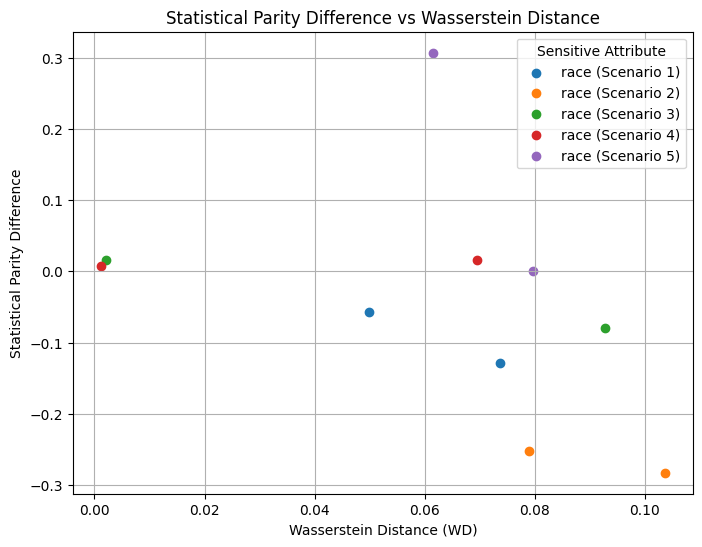

In [97]:
stat_parity = [
    all_sp_1,
    all_sp_2,
    all_sp_3,
    all_sp_4,
    #all_sp_5,
    all_sp_6
]

wd_values = [
    was_dist_1,
    was_dist_2,
    was_dist_3,
    was_dist_4,
    #was_dist_5,
    was_dist_6
]

attribute = 'race'

# Plot settings
plt.figure(figsize=(8, 6))

for x in range(len(stat_parity)):

    # Scenario 1
    x_values = wd_values[x][attribute]
    y_raw = stat_parity[x][attribute]
    y_values = [y - y_raw[0] for y in y_raw]
    plt.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")

# Add titles and labels
plt.title(f"Statistical Parity Difference vs Wasserstein Distance")
plt.xlabel("Wasserstein Distance (WD)")
plt.ylabel("Statistical Parity Difference")
plt.legend(title="Sensitive Attribute")
plt.grid(True)
plt.show()